# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [2]:
import time
import twitter
import re
import string
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from PIL import Image
from os import path
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
CONSUMER_KEY = "r7SgGbAISQkXcDW38aYEy6YuC"
CONSUMER_SECRET = "BnBkvzA1bsx2yT86y6lvqobpCbDtu2AnCIlXP9GoNAys3EeN6Y"

ACCESS_TOKEN_KEY = "703237592247111680-615HzJAd8hgUE5rT8h7llwKAg2QisvB"
ACCESS_TOKEN_SECRET = "FFeSml0efPaenCQcTrP7C6ePNRSe1YqdaUKzUrdM7inkY"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [4]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    tweet = []
    try:
        tweet = api.GetUserTimeline(user_id, count=200, exclude_replies=True)  
    except twitter.TwitterError as err:
        sec = api.GetSleepTime('/statuses/user_timeline')
        print "sleep for {} sec.".format(sec)
        time.sleep(sec)
        
    tweet = map(lambda s: s.AsDict(), tweet)
    tweet = filter(lambda t: t['lang'] == u'en', tweet)
    tweet = filter(lambda t: t['retweeted'] == False, tweet)
    tweet = filter(lambda t: len(re.findall(r'https?://[^\s<>"]+|www\.[^\s<>"]+', t['text'])) == 0, tweet)
                
    print "Tweets number: {}".format(len(tweet))
    return tweet

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [5]:
def get_words(text):
    """returns list of words"""
    return map(lambda s: re.sub(r"[{}]+".format(string.punctuation), r'', s), re.split('\s+', text))

In [6]:
print get_words("Here are different words!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [7]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [8]:
def get_tokens(words):
    """returns list of tokens"""
    lemms = nltk.stem.WordNetLemmatizer()
    return [lemms.lemmatize(w.lower()) for w in words if w not in nltk.corpus.stopwords.words('english')]

In [9]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [10]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet['text']))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [11]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    users = []
    frequence = []
    user_info = []
    
    count_user = len(df_users['uid'][1:])
    step = 100
    
    for i in xrange(0, count_user, step):
        usr = api.UsersLookup(list(df_users['uid'][1:])[i:i+step])
        user_info.extend(usr)
    
    for i, user_id in enumerate(df_users['uid'][1:]):
        if i < len(user_info):
            print "user #: {}".format(count_user) 
            print "UserID: {}".format(user_id)

            count_user -= 1

            if not user_info[i].protected:
                tweets = get_user_tweets(user_id)
                tokens = map(get_tweet_tokens, tweets)

                users.append(user_id)
                counter = reduce(lambda x, y: x + Counter(y), tokens, Counter())
                frequence.append(counter)
    return users, frequence

In [12]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

In [44]:
users, users_tokens = collect_users_tokens(df_users)

user #: 6897
UserID: 30005269
Tweets number: 65
user #: 6896
UserID: 3314758074
Tweets number: 41
user #: 6895
UserID: 14311688
Tweets number: 36
user #: 6894
UserID: 110457801
Tweets number: 38
user #: 6893
UserID: 269062860
Tweets number: 69
user #: 6892
UserID: 1656126090
Tweets number: 24
user #: 6891
UserID: 758669826
Tweets number: 136
user #: 6890
UserID: 21056856
Tweets number: 38
user #: 6889
UserID: 954363313
Tweets number: 122
user #: 6888
UserID: 337284868
Tweets number: 25
user #: 6887
UserID: 203541550
Tweets number: 74
user #: 6886
UserID: 156333623
Tweets number: 108
user #: 6885
UserID: 587865313
Tweets number: 86
user #: 6884
UserID: 4750028375
Tweets number: 66
user #: 6883
UserID: 115703194
Tweets number: 24
user #: 6882
UserID: 15475471
Tweets number: 6
user #: 6881
UserID: 2701352961
Tweets number: 78
user #: 6880
UserID: 383978282
Tweets number: 109
user #: 6879
UserID: 1031038448
Tweets number: 51
user #: 6878
UserID: 115402745
Tweets number: 15
user #: 6877
Use

KeyboardInterrupt: 

In [14]:
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [13]:
with np.load('files/out_4.dat.npz') as data:
    vs = data['data']
    users = data['users']
    users_tokens = data['users_tokens']

In [15]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [21]:
vs = v.fit_transform(users_tokens)[:,:100000] # delete if you have enough memory

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    plt.rcParams['figure.figsize'] = (10.0, 15.0)
    words = v.get_feature_names()[:100000]  #words = v.get_feature_names() # replace if you have enough memory
    vs_new = np.sum(vs.toarray(), axis=0)
    text = ' '.join([(word + ' ') * vs_new[i] for i, word in enumerate(words)])
    d = path.dirname('__file__')
    cloud = np.array(Image.open(path.join(d, "cloud.png")))
    
    wordcloud = WordCloud(mask=cloud, stopwords=set(list(STOPWORDS) + list(nltk.corpus.stopwords.words('english'))), 
                          background_color='white', max_words=600, width=3000, height=3000).generate(text)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

/home/helen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


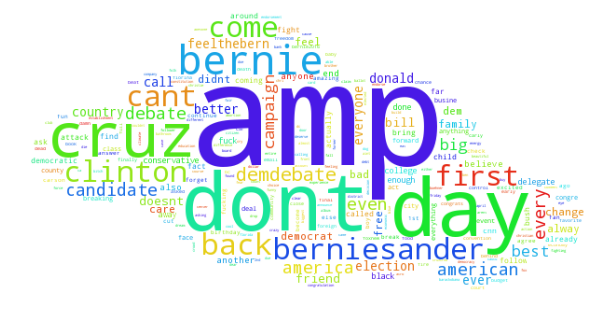

In [22]:
draw_tag_cloud(v, vs)